In [1]:
import os
os.system('cls' if os.name == 'nt' else 'clear')

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import importlib  # Pour recharger le module
pd.set_option('future.no_silent_downcasting', True)
from decimal import Decimal, getcontext
from config import config as cf

# Foyer

In [2]:
import main
importlib.reload(main)
df, SEMAINES = main.export_df_for_graph()

AttributeError: module 'main' has no attribute 'export_df_for_graph'

In [7]:
col_ajoutee = ("SOC_charge", "SOC_decharge", "Achat_t", "Well_0")
# Supprimer les colonnes ajoutées si elles existent déjà pour éviter les problèmes
for col in col_ajoutee : 
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Configurer la précision
getcontext().prec = 4  # 4 chiffres significatifs

# Appliquer aux données
df["Well"] = df["Well"].apply(lambda x: float(Decimal(str(x)).quantize(Decimal('0.001'))))
df["SOC_decharge"] = (df["Demande"] + df["Vente"] - df["Prod PV"] - df["Achat"]).clip(lower=0).round(3)
df["Achat_t"] = (df["Demande"] - df["Prod PV"] - df["SOC_t"]).clip(lower=0)
df["Well_0"] = (df["Prod PV"] - df["Demande"] - df["Vente"]).clip(lower=0).round(3)

# df.to_csv('/Users/vincentboltz/Documents/DOC_ENPC/Projet_IFPEN/Données brut/df_for_graph.csv', index=False, header=True)

# display(df.iloc[0:60])
def display_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    display(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
# display_full(df[df['Saison'] == 'hiver'])

# print(f'Well avec batterie tot = {df[df['Saison'] == 'ete']['Well'].sum()} kWh')

for semaine in SEMAINES.keys() :
    print('\n',{semaine}, ': ')
    print('Well avec batterie tot = ',df[df['Saison'] == semaine]['Well'].sum(), 'kWh')
    print('Prod PV tot = ',df[df['Saison'] == semaine]['Prod PV'].sum().round(3), 'kWh')
    print('Well sans batterie tot =', df[df['Saison'] == semaine]['Well_0'].sum().round(3), 'kWh')



NameError: name 'df' is not defined

##### Prix de l'électricité

In [8]:
def price_elec(saison) : 
    # Filtrer le DataFrame pour la plage de périodes sélectionnée
    filtered_df = df[(df["Saison"] == saison)].copy()

    # Créer le graphique
    plt.figure(figsize=(8, 4))

    plt.plot(filtered_df.index, filtered_df["Prix elec"], label="Prix de l'électricité", color="green", linewidth=0.7)

    # Min et max
    min_value = min(0, filtered_df["Prix elec"].min()*1.2)
    max_value = filtered_df["Prix elec"].max()*1.1

    # Ajouter labels, titre, légende, grille
    plt.xlabel("Période")
    plt.ylabel("Prix de l'électricité €/MWh")
    plt.title(f"Prix de l'électricité d'une semaine type pour la saison : {saison}")
    plt.ylim(min_value, max_value)
    plt.legend()
    plt.grid(True)

    plt.show()

def plot_prices_on_single_figure(df, saisons_list):
    # Créer une figure avec 4 subplots (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle("Prix de l'électricité par saison (semaine type)", y=1.02, fontsize=14)
    
    # Déterminer les limites communes des axes Y
    y_max = df["Prix elec"].max() * 1.1
    y_min = df["Prix elec"].min() * 1.1
    
    for i, saison in enumerate(saisons_list):
        filtered_df = df[df["Saison"] == saison].copy()
        ax = axes[i//2, i%2]  # Positionnement dans la grille 2x2
        
        # Tracer le prix
        ax.plot(filtered_df.index, filtered_df["Prix elec"], 
                label="Prix électricité", color="green", linewidth=0.7)
        
        jour_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
        ax.set_xticks(filtered_df.index[::24])
        ax.set_xticklabels(jour_semaine)

        # Paramètres du subplot
        ax.set_title(f"Saison : {saison}")
        ax.set_xlabel("Période")
        ax.set_ylabel("€/MWh")
        ax.set_ylim(y_min, y_max)  # Même échelle Y pour tous
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()  # Ajuster l'espacement
    plt.show()

plot_prices_on_single_figure(df, SEMAINES.keys())

# price_elec("ete")


NameError: name 'df' is not defined

ValueError: x and y must have same first dimension, but have shapes (169,) and (0,)

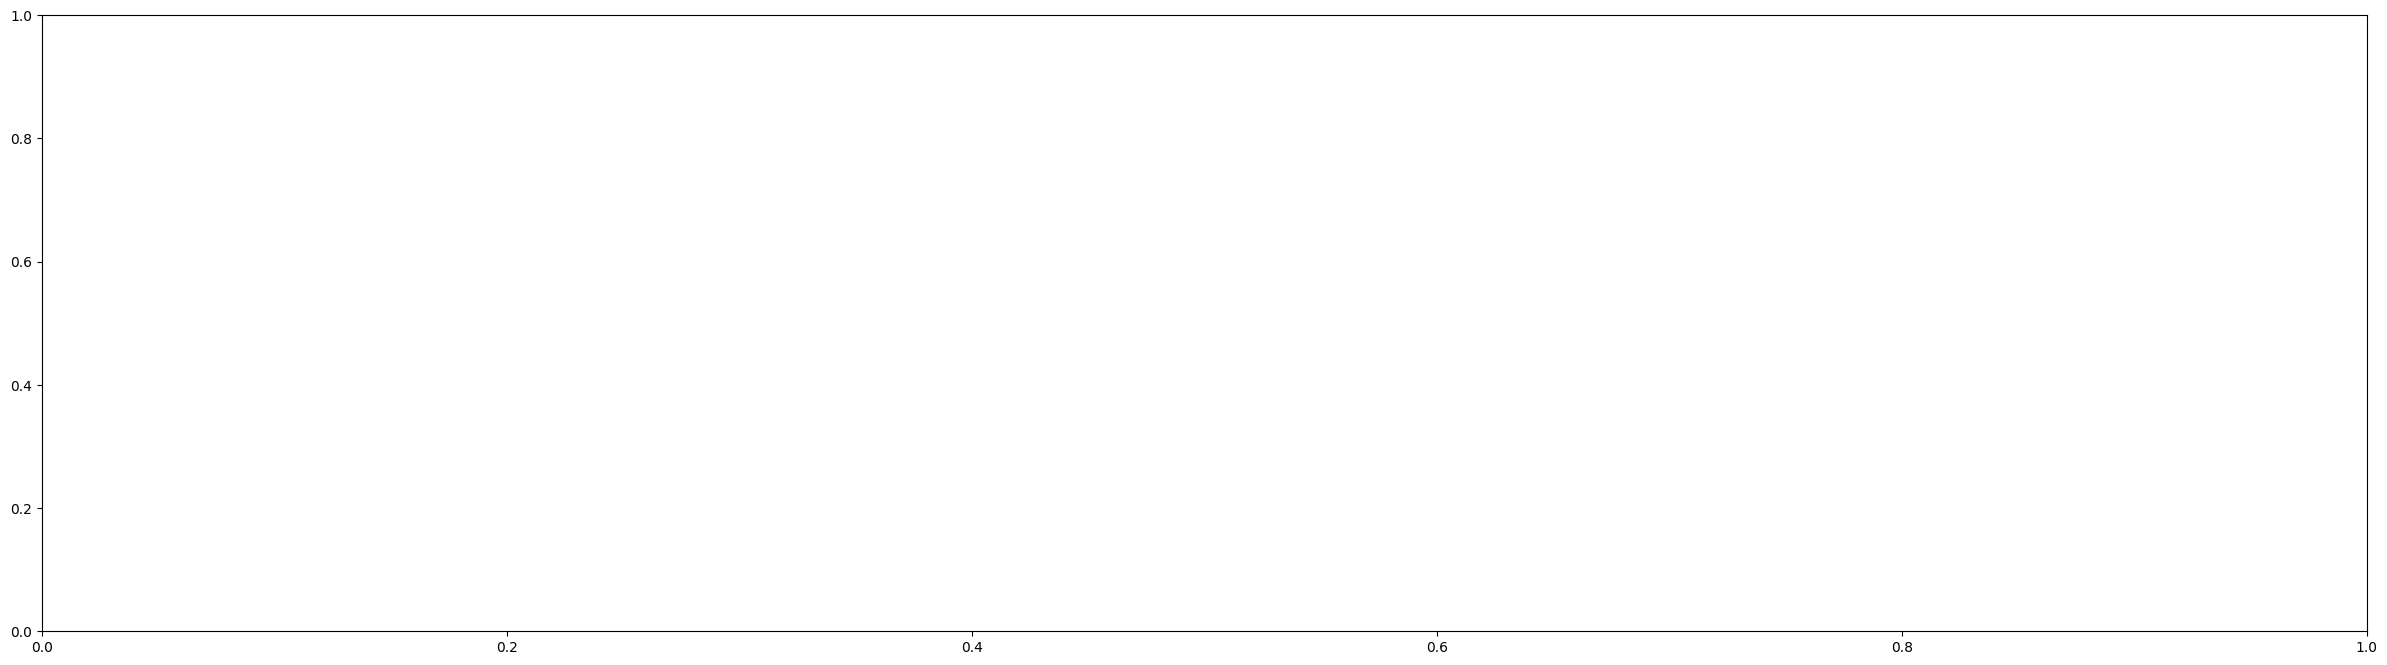

In [3]:
import elec_price_layer

{   "hiver" : [list(range(72, 241)), []], 
    "printemps" : [list(range(2256, 2425)), []],
    "ete" : [list(range(4440, 4609)), []],
    "automne" : [list(range(6624, 6793)), []]
}

# # Calcul du prix de l'électricité (plusieurs tirages)
# N_TIRAGES = 100  # Nombre de tirages par pas de temps
# cf.ELECPRICE = [0] * cf.PERIODS
# current_regime = None
# for semaine in cf.SEMAINES :
#     elecprice_df = pd.DataFrame()
#     start_idx = cf.SEMAINES[semaine][0][0]
#     end_idx = cf.SEMAINES[semaine][0][-1] + 1

#     for n in range(N_TIRAGES):
#         elecprice_unit = []

#         for t in range(start_idx, end_idx):
#             current_regime, price = elec_price_layer.elec_price(t, current_regime, cf.DF_PRODVALUES)
#             elecprice_unit.append(round(price, 2))
#         elecprice_df[n] = elecprice_unit

#     # Calcul du prix moyen par période horaire
#     prix_moyen = elecprice_df.mean(axis=0).tolist()

#     for i, prix in enumerate(prix_moyen):
#         cf.ELECPRICE[start_idx + i] = prix

plot_range = range(4440,4609)
plt.figure(figsize=(30, 8))
plt.plot(plot_range, cf.ELECPRICE[4440:4609], 'b-', linewidth=2, label='Prix moyen')
plt.xlabel('Périodes')
plt.ylabel('Prix (€/MWh)')
plt.title('Évolution du prix de l\'électricité\n(Moyenne sur {} tirages Markov)'.format(N_TIRAGES))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [18]:
print("Nombre d'utilisation de la batterie dans la semaine :", (df['SOC_decharge'] != 0).sum())

Nombre d'utilisation de la batterie dans la semaine : 230


##### Comportement **hebdomadaire** de la batterie (décomposition de l'équilibre offre-demande)

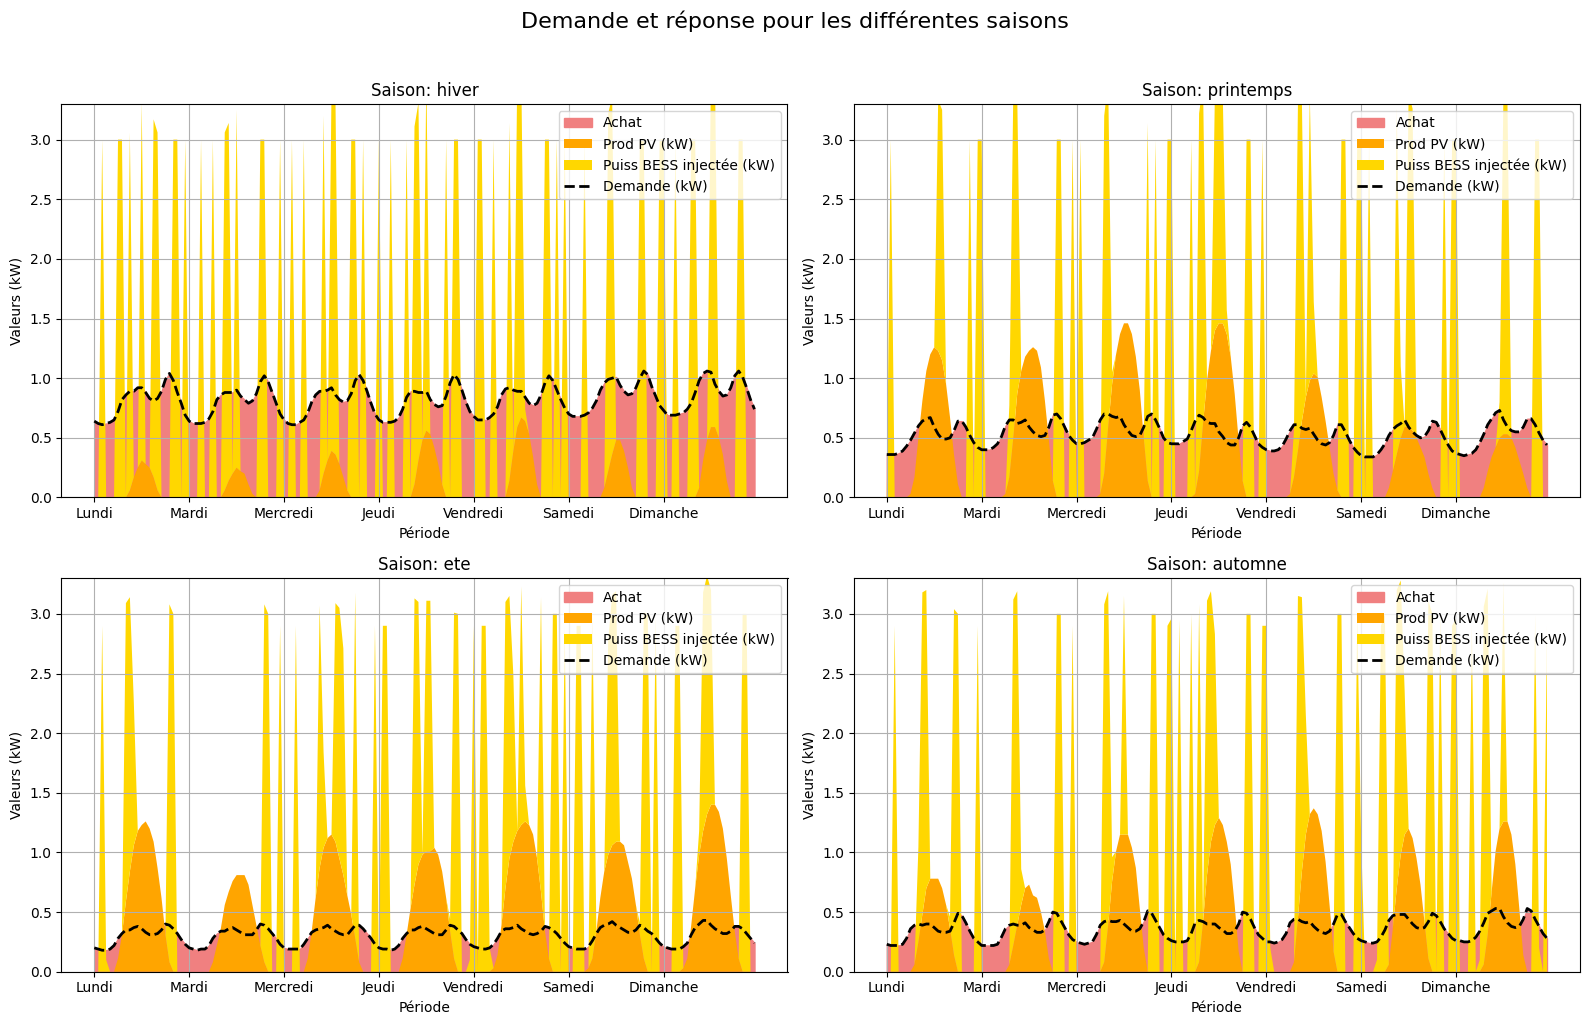

In [19]:
def bess_injected(saison):    
    # Filtrer le DataFrame pour la plage de périodes sélectionnée
    filtered_df = df[(df["Saison"] == saison)].copy()

    # Nettoyage des données
    filtered_df["Prod PV"] = filtered_df["Prod PV"].fillna(0).astype(float)
    filtered_df["SOC_decharge"] = filtered_df["SOC_decharge"].fillna(0).astype(float)
    

    # Créer le graphique
    plt.figure(figsize=(8, 4))

    # Utiliser la coubre "Demande" pour afficher l'électricité qu'il reste à acheter (car la colonne "Achat_t" ne fonctionn pas)
    plt.fill_between(filtered_df.index, filtered_df["Demande"], label="Achat", color="pink", alpha=1)  # Remplissage

    # Tracer les zones empilées pour "Prod PV" et "SOC_t"
    plt.stackplot(
        filtered_df.index,  # Axe X (périodes)
        filtered_df["Prod PV"],  # Première zone (Prod PV)
        filtered_df["SOC_decharge"],    # Deuxième zone (SOC_t)
        labels=["Prod PV (kW)", "Puiss BESS injectée (kW)"],  # Labels pour la légende
        colors=["orange", "gold"],     # Couleurs des zones
        alpha=1                               # Transparence
    )
    
    # Tracer la Demande comme une courbe normale
    plt.plot(filtered_df.index, filtered_df["Demande"], label="Demande (kW)", color="black", linestyle = '--' , linewidth=2)

    # Ajouter labels, titre, légende, grille
    plt.xlabel("Période")
    plt.ylabel("Valeurs (kW)")
    plt.title(f"Demande et réponse d'une semaine type (Saison : {saison})")
    # plt.xticks(range(start_period, end_period + 1, 3))  # Tics toutes les 3 périodes
    plt.ylim(0, max(df["Demande"].max(), df["Prod PV"].max(), df["SOC_decharge"].max())*1.1)
    plt.legend(loc="upper right")  # Position de la légende en haut à droite
    
    plt.grid(True)

    # Afficher le graphique
    plt.show()

# for semaine in SEMAINES_LIST : 
#     bess_injected(semaine)

def plot_all_seasons(df, saisons_list):
    # Créer une figure avec 4 sous-graphiques (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle("Demande et réponse pour les différentes saisons", y=1.02, fontsize=16)
    
    # Déterminer les limites communes des axes Y
    y_max = max(df["Demande"].max(), df["Prod PV"].max(), df["SOC_decharge"].max()) * 1.1
    
    for i, saison in enumerate(saisons_list):
        ax = axes[i//2, i%2]  # Positionnement dans la grille
        filtered_df = df[df["Saison"] == saison].copy()
        
        # Nettoyage des données
        filtered_df["Prod PV"] = filtered_df["Prod PV"].fillna(0).astype(float)
        filtered_df["SOC_decharge"] = filtered_df["SOC_decharge"].fillna(0).astype(float)
        
        # Remplissage pour "Achat"
        ax.fill_between(filtered_df.index, filtered_df["Demande"], label="Achat", color="lightcoral", alpha=1)
        
        # Stackplot
        ax.stackplot(filtered_df.index,
                    filtered_df["Prod PV"],
                    filtered_df["SOC_decharge"],
                    labels=["Prod PV (kW)", "Puiss BESS injectée (kW)"],
                    colors=["orange", "gold"],
                    alpha=1)
        
        # Courbe de demande
        ax.plot(filtered_df.index, filtered_df["Demande"], label="Demande (kW)", color="black", linestyle='--', linewidth=2)
        
        jour_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
        ax.set_xticks(filtered_df.index[::24])
        ax.set_xticklabels(jour_semaine)
        
        # Paramètres du sous-graphique
        ax.set_title(f"Saison: {saison}")
        ax.set_xlabel("Période")
        ax.set_ylabel("Valeurs (kW)")
        ax.set_ylim(0, y_max)
        ax.legend(loc="upper right")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Appel de la fonction
plot_all_seasons(df, SEMAINES.keys())

##### Comportement **journalier** de la batterie (décomposition de l'équilibre offre-demande)

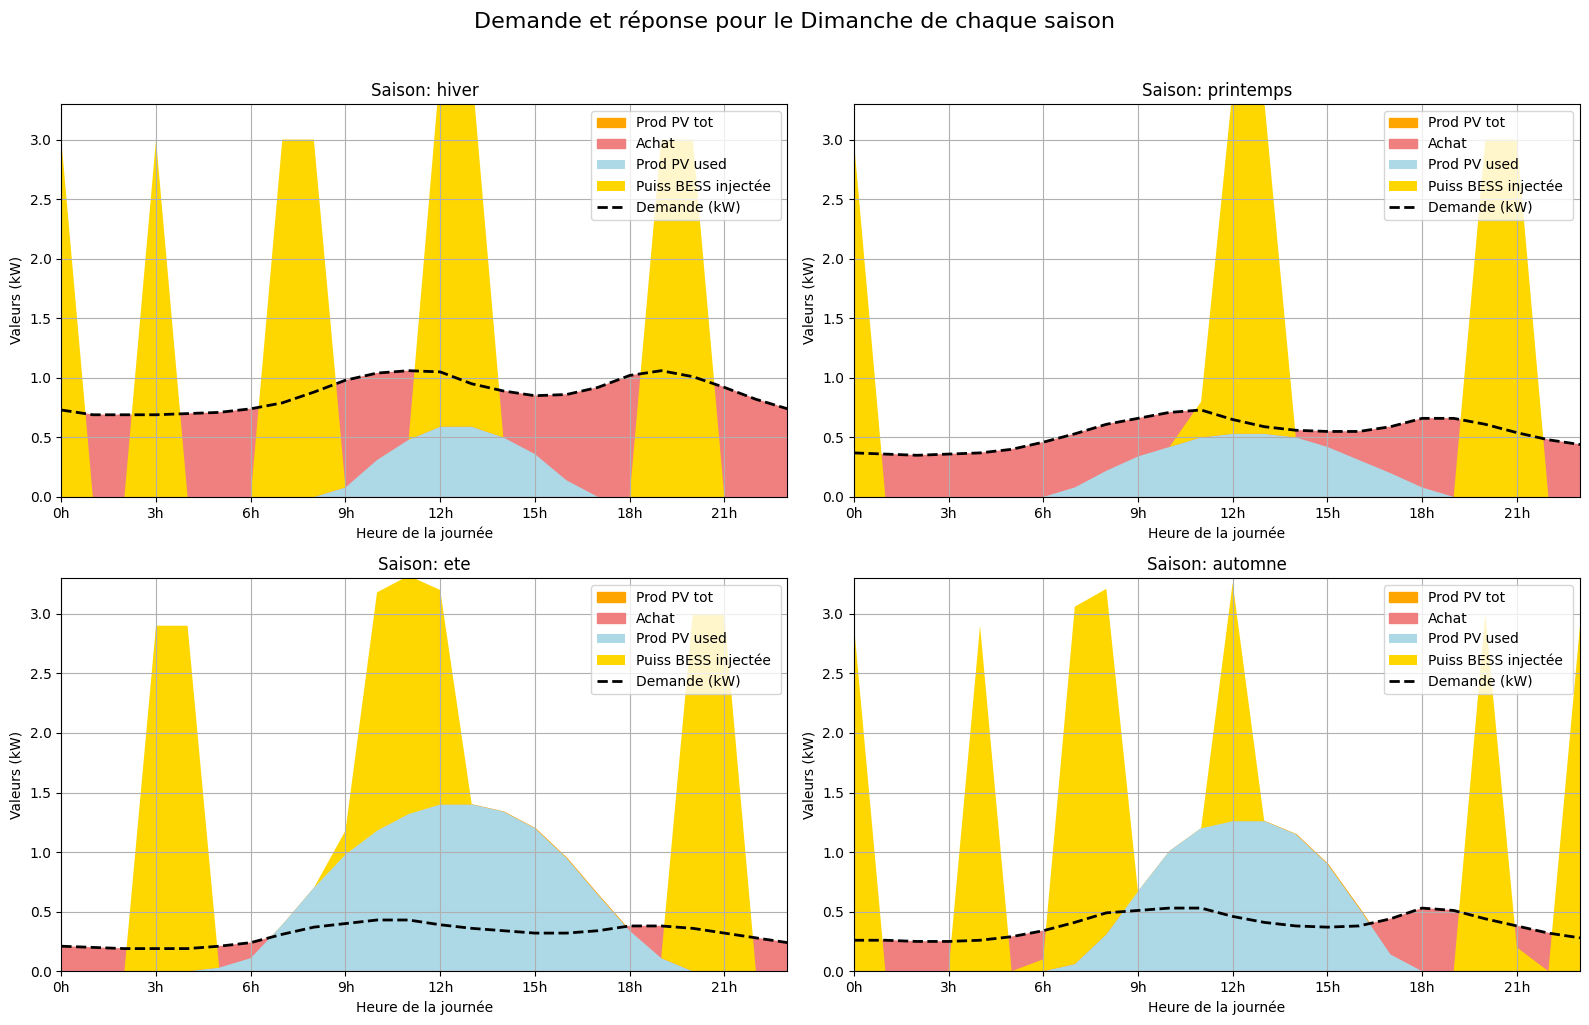

In [20]:
def plot_all_seasons_day(df, saisons_list, jour_cible):
    # Mapping des jours de la semaine
    jours_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
    
    # Créer une figure avec 4 sous-graphiques (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Demande et réponse pour le {jour_cible} de chaque saison", y=1.02, fontsize=16)
    
    # Déterminer les limites communes des axes Y
    y_max = max(df["Demande"].max(), df["Prod PV"].max(), df["SOC_decharge"].max()) * 1.1
    
    for i, saison in enumerate(saisons_list):
        ax = axes[i//2, i%2]  # Positionnement dans la grille
        
        # Filtrer la saison et extraire le jour cible
        filtered_df = df[df["Saison"] == saison].copy()
        idx_jour = jours_semaine.index(jour_cible)
        daily_data = filtered_df.iloc[idx_jour*24 : (idx_jour+1)*24].copy()  # Extraire 24h pour le jour cible
        
        # Nettoyage des données
        daily_data["Prod PV"] = daily_data["Prod PV"].fillna(0).astype(float)
        daily_data["SOC_decharge"] = daily_data["SOC_decharge"].fillna(0).astype(float)
        
        # Remplissage pour "Achat"
        ax.fill_between(range(24), daily_data["Demande"], label="Achat", color="lightcoral", alpha=1)
        
        # Stackplot
        ax.stackplot(range(24),
                    daily_data["Prod PV"],
                    daily_data["SOC_decharge"],
                    labels=["Prod PV (kW)", "Puiss BESS injectée (kW)"],
                    colors=["orange", "gold"],
                    alpha=1)
        
        # Courbe de demande
        ax.plot(range(24), daily_data["Demande"], label="Demande (kW)", color="black", linestyle='--', linewidth=2)
        
        # Configuration des ticks horaires
        ax.set_xticks(range(0, 24, 3))
        ax.set_xticklabels([f"{h}h" for h in range(0, 24, 3)])
        
        # Paramètres du sous-graphique
        ax.set_title(f"Saison: {saison}")
        ax.set_xlabel("Heure de la journée")
        ax.set_ylabel("Valeurs (kW)")
        ax.set_xlim(0, 23)
        ax.set_ylim(0, y_max)
        ax.legend(loc="upper right")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_all_seasons_day_well(df, saisons_list, jour_cible):
    # Mapping des jours de la semaine
    jours_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
    
    # Créer une figure avec 4 sous-graphiques (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Demande et réponse pour le {jour_cible} de chaque saison", y=1.02, fontsize=16)
    
    # Déterminer les limites communes des axes Y
    y_max = max(df["Demande"].max(), df["Prod PV"].max(), df["SOC_decharge"].max()) * 1.1
    
    for i, saison in enumerate(saisons_list):
        ax = axes[i//2, i%2]  # Positionnement dans la grille
        
        # Filtrer la saison et extraire le jour cible
        filtered_df = df[df["Saison"] == saison].copy()
        idx_jour = jours_semaine.index(jour_cible)
        daily_data = filtered_df.iloc[idx_jour*24 : (idx_jour+1)*24].copy()  # Extraire 24h pour le jour cible
        
        # Nettoyage des données
        daily_data["Prod PV"] = daily_data["Prod PV"].fillna(0).astype(float)
        daily_data["SOC_decharge"] = daily_data["SOC_decharge"].fillna(0).astype(float)
        
        # Remplissage pour "Achat"
        ax.fill_between(range(24), daily_data["Prod PV"], label="Prod PV tot", color="orange", alpha=1)
        ax.fill_between(range(24), daily_data["Demande"], label="Achat", color="lightcoral", alpha=1)
        
        # Stackplot
        ax.stackplot(range(24),
                    daily_data["Prod PV"] - daily_data["Well"].round(3),
                    daily_data["SOC_decharge"],
                    labels=["Prod PV used", "Puiss BESS injectée "],
                    colors=["lightblue", "gold"],
                    alpha=1)
        
        # Courbe de demande
        ax.plot(range(24), daily_data["Demande"], label="Demande (kW)", color="black", linestyle='--', linewidth=2)
        
        # Configuration des ticks horaires
        ax.set_xticks(range(0, 24, 3))
        ax.set_xticklabels([f"{h}h" for h in range(0, 24, 3)])
        
        # Paramètres du sous-graphique
        ax.set_title(f"Saison: {saison}")
        ax.set_xlabel("Heure de la journée")
        ax.set_ylabel("Valeurs (kW)")
        ax.set_xlim(0, 23)
        ax.set_ylim(0, y_max)
        ax.legend(loc="upper right")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# --- Appel des fonctions --- #
# plot_all_seasons_day(df, SEMAINES.keys(), 'Mercredi')
plot_all_seasons_day_well(df, SEMAINES.keys(), 'Dimanche')

##### Évolution du SOC de la batterie

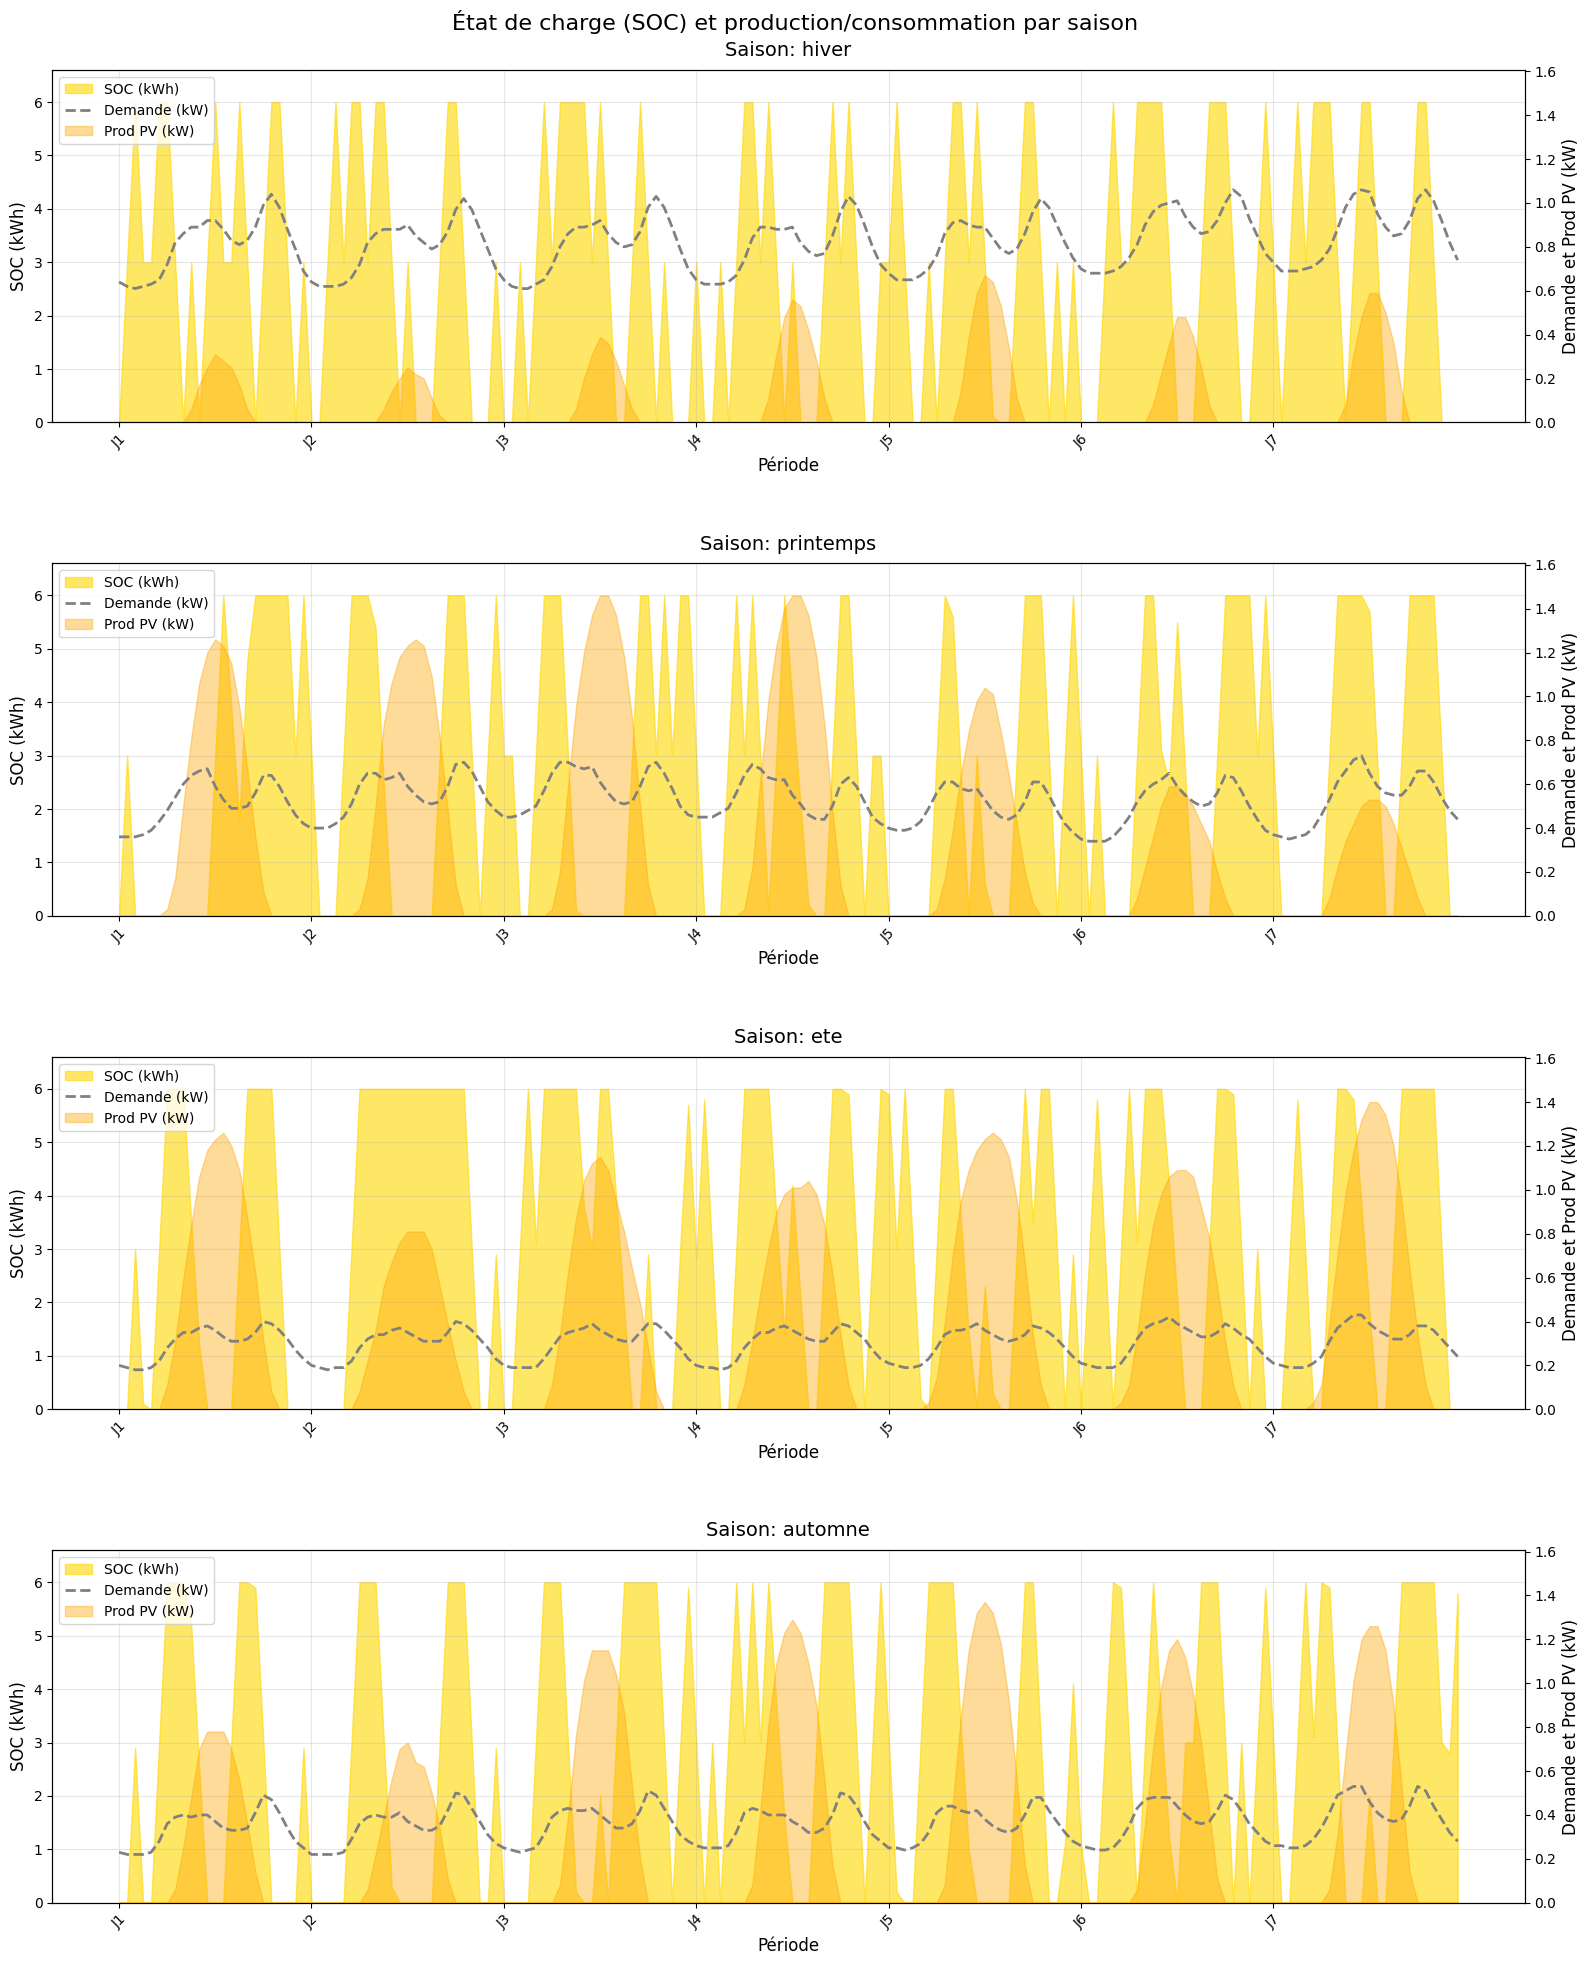

In [21]:
def soc(saison) :
    # Filtrer le DataFrame pour la plage de périodes sélectionnée
    filtered_df = df[(df["Saison"] == saison)].copy()
    
    # Créer une figure et un premier axe Y
    fig, ax1 = plt.subplots(figsize=(8, 4))

    ax1.fill_between(filtered_df.index, filtered_df["SOC_t"], label="SOC (kWh)", color="gold", alpha=0.6)

    ax1.set_xlabel("Périodes")
    ax1.set_ylabel("SOC (kWh)")
    ax1.tick_params(axis='y')
    ax1.grid(True)

    # Créer un deuxième axe Y partageant le même axe X
    ax2 = ax1.twinx()

    # Tracer la Demande et la Prod PV sur le premier axe Y (kWh)
    ax2.plot(filtered_df.index, filtered_df["Demande"], label="Demande (kW)", linestyle='--', color="grey", linewidth=2)
    ax2.fill_between(filtered_df.index, filtered_df["Prod PV"], label="Prod PV (kW)", color="orange", alpha=0.4)

    # Configurer le deuxième axe Y
    ax2.set_xlabel("Période")
    ax2.set_ylabel("Demande et Prod PV (kW)")    
    ax2.tick_params(axis='y')

    # ax1.set_xticks(range(start_period, end_period + 1, 3))  # Tics toutes les 3 périodes

    # Ajouter un titre
    plt.title(f"Demande, Prod PV et SOC_tot d'une semaine type (Saison : {saison})")
    ax1.set_ylim(0, df["SOC_t"].max()*1.1)
    ax2.set_ylim(0, max(df["Demande"].max(), df["Prod PV"].max())*1.1)

    # Combiner les légendes des deux axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.show()

def plot_all_seasons_soc_vertical(df, saisons_list):
    # Créer une figure avec 4 sous-graphiques verticaux (4x1)
    fig, axes = plt.subplots(4, 1, figsize=(16, 20))  # Largeur augmentée, hauteur adaptée
    fig.suptitle("État de charge (SOC) et production/consommation par saison", y=0.98, fontsize=16)
    
    # Déterminer les limites communes des axes Y
    soc_max = df["SOC_t"].max() * 1.1
    demand_pv_max = max(df["Demande"].max(), df["Prod PV"].max()) * 1.1
    
    for i, saison in enumerate(saisons_list):
        # Sélectionner l'axe correspondant
        ax1 = axes[i]  # Chaque graphique sur sa propre ligne
        
        # Filtrer la saison
        filtered_df = df[df["Saison"] == saison].copy()
        
        # Premier axe Y (SOC)
        ax1.fill_between(filtered_df.index, filtered_df["SOC_t"], label="SOC (kWh)", color="gold", alpha=0.6)
        ax1.set_ylabel("SOC (kWh)", fontsize=12)
        ax1.tick_params(axis='y')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, soc_max)
        
        # Deuxième axe Y (Demande et Prod PV)
        ax2 = ax1.twinx()
        ax2.plot(filtered_df.index, filtered_df["Demande"], label="Demande (kW)", linestyle='--', color="grey", linewidth=2)
        ax2.fill_between(filtered_df.index, filtered_df["Prod PV"], label="Prod PV (kW)", color="orange", alpha=0.4)
        ax2.set_ylabel("Demande et Prod PV (kW)", fontsize=12)
        ax2.tick_params(axis='y')
        ax2.set_ylim(0, demand_pv_max)
        
        # Configuration des ticks (toutes les 24 périodes)
        ax1.set_xticks(filtered_df.index[::24])
        ax1.set_xticklabels([f'J{i//24 + 1}' for i in range(0, len(filtered_df), 24)], rotation=45)
        
        # Paramètres du sous-graphique
        ax1.set_title(f"Saison: {saison}", fontsize=14, pad=10)
        ax1.set_xlabel("Période", fontsize=12)
        
        # Combiner les légendes des deux axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=10)
    
    # Ajuster l'espacement entre les sous-graphiques
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.4)  # Plus d'espace vertical entre les graphiques
    plt.show()

# Appel de la fonction
plot_all_seasons_soc_vertical(df, list(SEMAINES.keys()))  # Convertir en liste pour l'ordre

# National

In [68]:
RESULTS_DIR = cf.PROJECT_ROOT / "data" / "Modele_chronologique" / "results.csv"

df_nat = pd.read_csv(RESULTS_DIR, delimiter=',') 
display(df_nat.iloc[473:493])
print("Différence brute/nette = ", df_nat["demande brute"].sum() - df_nat["demande nette"].sum())

,periode,demande brute,demande nette
473,474,69610.0,66610.0
474,475,73582.0,76582.0
475,476,75613.5,75613.5
476,477,71814.0,68814.0
477,478,67143.0,67143.0
478,479,64531.0,67531.0
479,480,65968.5,62968.5
480,481,64634.5,61634.5
481,482,61718.5,64718.5
482,483,61162.5,58162.5


Différence brute/nette =  -1064660.0


##### Demande annuelle MW

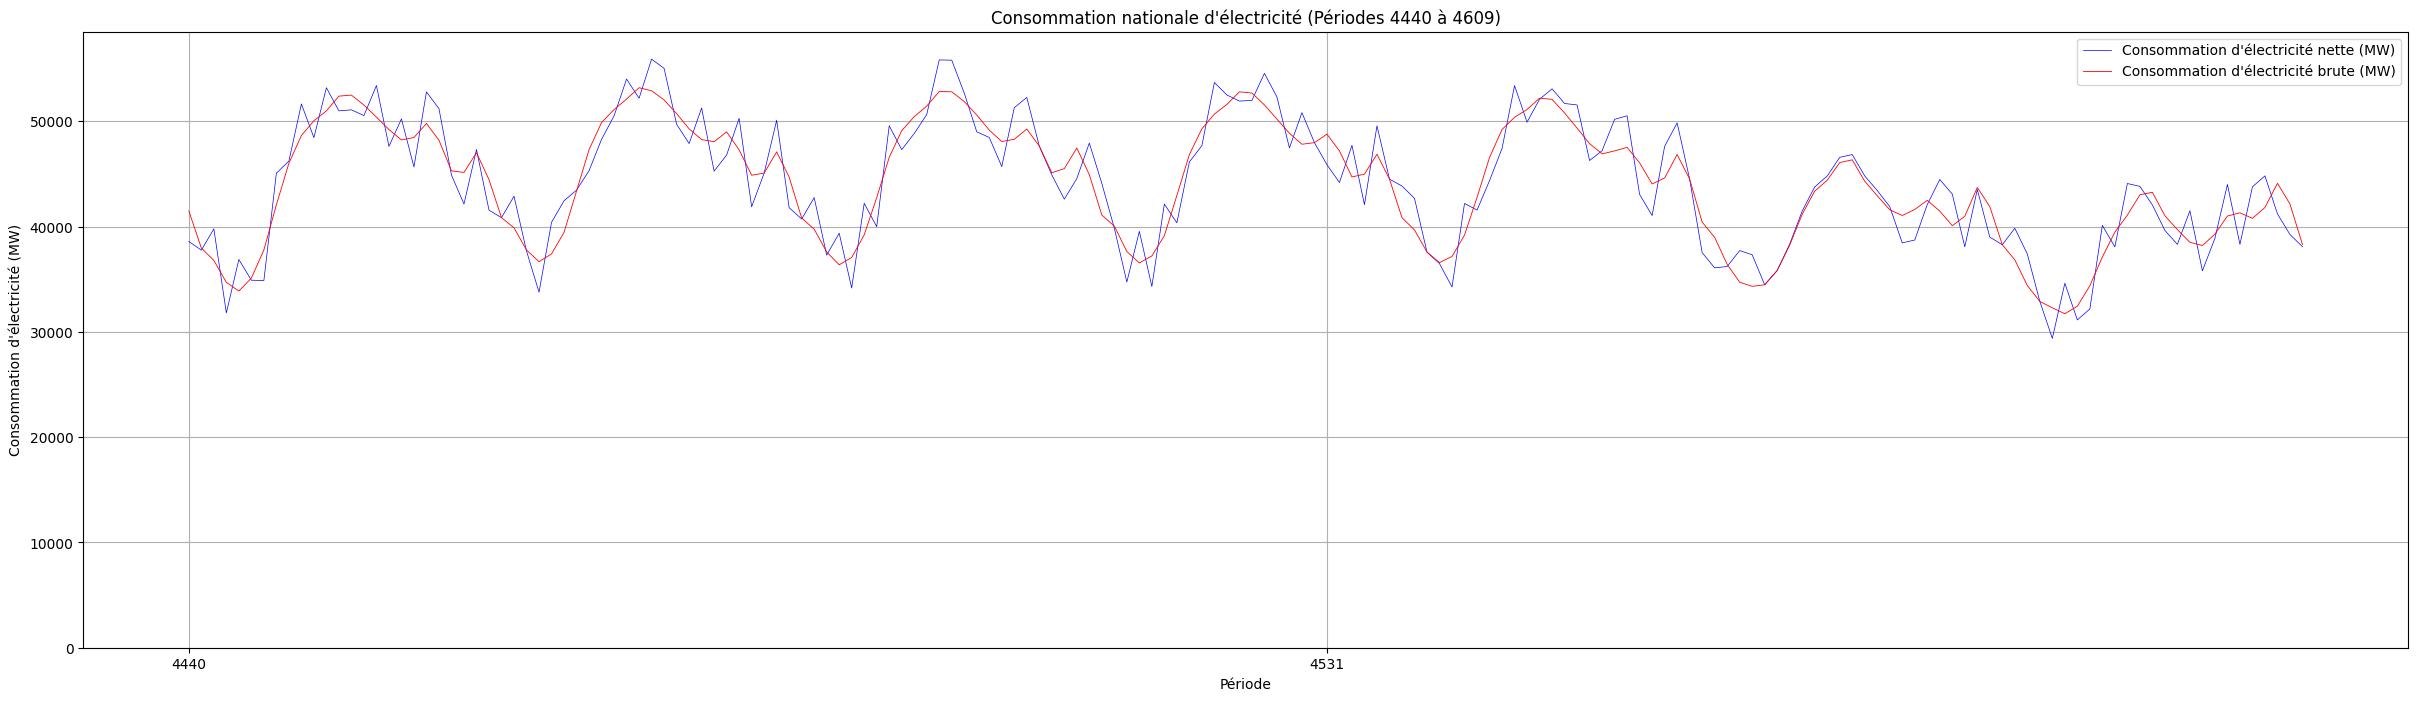

In [69]:
def graph(period) : 
    start_period, end_period = period
    # Filtrer le DataFrame pour la plage de périodes sélectionnée
    filtered_df = df_nat[(df_nat.index >= start_period) & (df_nat.index <= end_period)].copy()

    # Créer le graphique
    plt.figure(figsize=(30, 8))
    
    plt.plot(filtered_df.index, filtered_df["demande nette"], label="Consommation d'électricité nette (MW)", color="blue", linewidth=0.5)
    plt.plot(filtered_df.index, filtered_df["demande brute"], label="Consommation d'électricité brute (MW)", color="red", linewidth=0.6)

    # Ajouter labels, titre, légende, grille
    plt.xlabel("Période")
    plt.ylabel("Consommation d'électricité (MW)")
    plt.title(f"Consommation nationale d'électricité (Périodes {start_period} à {end_period})")
    plt.xticks(range(start_period, end_period + 1, 91))  # Tics toutes les 3 périodes
    plt.ylim(0, filtered_df["demande brute"].max()*1.1)
    plt.legend()
    plt.grid(True)

    plt.show()

graph((4440, 4609))